# Лабораторная работа 7

В качестве датасета был взят https://www.kaggle.com/datasets/sadhliroomyprime/cricket-semantic-segmentation

Сегментацию спортивных матчей по крикету можно использовать для автоматизации операторской работы, быстрой нарезки хайлатов и автоматизированной аналитики матчей.

## Метрики

Для данной задачи семантической сегментации будут использоваться следующие метрики качества:

1. Pixel Accuracy (PA) — метрика, отражающая точность классификации на уровне пикселей. Она рассчитывается как отношение количества корректно предсказанных пикселей к общему числу пикселей на изображении. Данная метрика даёт общее представление о том, насколько модель справляется с задачей в целом, однако она может быть неинформативна при наличии дисбаланса классов.

2. Intersection over Union (IoU) — одна из ключевых метрик для оценки качества сегментации. Рассчитывается как отношение площади пересечения предсказанной и истинной масок к площади их объединения:

IoU
=
Площадь пересечения /
Площадь объединения


Площадь пересечения — это число пикселей, правильно предсказанных как принадлежащие определённому классу (совпадение предсказания и разметки).

Площадь объединения — общее число пикселей, отнесённых к классу либо моделью, либо в аннотации (без повторов).

Значение IoU варьируется от 0 до 1:

0 означает полное отсутствие совпадений между предсказанием и истинной маской,

1 — полное совпадение (идеальная сегментация).

IoU более чувствительна к ошибкам в локализации и чаще используется для детальной оценки модели на уровне каждого класса.

In [ ]:
!pip install kaggle
!pip install opendatasets
!pip install pandas
!pip install segmentation_models_pytorch

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/sadhliroomyprime/cricket-semantic-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xbhgbz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sadhliroomyprime/cricket-semantic-segmentation


In [ ]:
import os
import json
import cv2
import torch
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
im_h, im_w = 512, 512
image_extensions = [".png"]
split=(0.9, 0.05, 0.05)

def read_json(path):
    with open(path, 'r') as f:
        return json.load(f)

def read_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def get_image_files(root, extensions):
    all_files = []
    for ext in extensions:
        all_files.extend(glob(os.path.join(root, "images", f"*{ext}")))
    return sorted(all_files)

def get_split_name(path):
    return os.path.splitext(os.path.basename(path))[0]

def filter_image_paths(image_paths):
    return [p for p in image_paths if "___" not in get_split_name(p)]

def filter_gt_paths(image_paths):
    return [p for p in image_paths if "fuse" in get_split_name(p)]

def get_paths(root, extensions):
    all_images = get_image_files(root, extensions)
    return filter_image_paths(all_images), filter_gt_paths(all_images)

def apply_transforms(image, mask, transform):
    transformed = transform(image=image, mask=mask)
    return transformed["image"], transformed["mask"]

def create_dataset(im_paths, gt_paths, transform, n_classes):
    def get_item(idx):
        image = read_image(im_paths[idx])
        mask = read_image(gt_paths[idx])
        if transform:
            image, mask = apply_transforms(image, mask, transform)
        return image, (mask // (n_classes * 4)).long()

    dataset_len = len(im_paths)
    return type('AnonymousDataset', (Dataset,), {
        '__len__': lambda self: dataset_len,
        '__getitem__': lambda self, idx: get_item(idx)
    })()

data_path = "/content/cricket-semantic-segmentation/data"
transform = A.Compose([
    A.Resize(im_h, im_w),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(transpose_mask=True)
])

im_paths, gt_paths = get_paths(data_path, image_extensions)
n_classes = len(read_json(os.path.join(data_path, "classes", "classes.json")))

dataset = create_dataset(im_paths, gt_paths, transform, n_classes)

train_len = int(len(dataset) * split[0])
val_len = int(len(dataset) * split[1])
test_len = len(dataset) - train_len - val_len

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

print(f"\n[INFO] Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

tr_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


[INFO] Train: 268 | Val: 14 | Test: 16


# 2 Бейзлайн

In [ ]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=n_classes)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import time
import os
from tqdm import tqdm

def to_contiguous(inp):
    return inp.contiguous().view(-1)

def compute_pa(pred, gt):
    with torch.no_grad():
        pred_labels = torch.argmax(F.softmax(pred, dim=1), dim=1)
        gt_labels = torch.argmax(gt, dim=1) if gt.ndim == 4 else gt
        match = (pred_labels == gt_labels).int()
    return float(match.sum()) / float(match.numel())

def compute_miou(pred, gt, n_cls, eps=1e-10):
    with torch.no_grad():
        pred_labels = torch.argmax(F.softmax(pred, dim=1), dim=1)
        gt_labels = torch.argmax(gt, dim=1) if gt.ndim == 4 else gt
        pred_flat = to_contiguous(pred_labels)
        gt_flat = to_contiguous(gt_labels)

        iou_per_class = []
        for c in range(n_cls):
            match_pred = pred_flat == c
            match_gt = gt_flat == c

            if match_gt.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                union = torch.logical_or(match_pred, match_gt).sum().float().item()
                iou = (intersect + eps) / (union + eps)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def compute_loss(pred, gt, loss_fn):
    gt_labels = torch.argmax(gt, dim=1) if gt.ndim == 4 else gt
    return loss_fn(pred, gt_labels)

def tic_toc(start_time=None):
    return time.time() if start_time is None else time.time() - start_time

def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path="saved_models", n_cls=9):
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve = np.inf, 1, 0
    early_stop_threshold = 7

    os.makedirs(save_path, exist_ok=True)
    model.to(device)

    train_start = tic_toc()
    print("Start training process...")
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for ims, gts in tqdm(tr_dl):
            ims, gts = ims.to(device), gts.to(device)
            preds = model(ims)
            loss_ = compute_loss(preds, gts, loss_fn)
            tr_loss_ += loss_.item()
            tr_pa_ += compute_pa(preds, gts)
            tr_iou_ += compute_miou(preds, gts, n_cls)
            loss_.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        print(f"Epoch {epoch} validation process is started...")
        with torch.no_grad():
            for ims, gts in tqdm(val_dl):
                ims, gts = ims.to(device), gts.to(device)
                preds = model(ims)
                val_loss_ += compute_loss(preds, gts, loss_fn).item()
                val_pa_ += compute_pa(preds, gts)
                val_iou_ += compute_miou(preds, gts, n_cls)

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"Epoch {epoch} train process results:")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")
        if val_loss_ < best_loss:
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")
        else:
            not_improve += 1
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print("Stopping training due to early stopping criteria.")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)
        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

    print(f"Training completed in {(tic_toc(train_start)) / 60:.2f} minutes.")
    return {
        "tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
        "val_loss": val_loss, "val_iou": val_iou, "val_pa": val_pa
    }

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model=model, tr_dl=tr_dl, val_dl=val_dl, loss_fn=loss_fn, opt=optimizer,device=device,epochs=5,save_prefix="cricket",n_cls=n_classes)

Start training process...
Epoch 1 train process is started...


100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Epoch 1 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 train process results:
Train Time         -> 16.338 secs
Train Loss         -> 1.862
Train PA           -> 0.438
Train IoU          -> 0.158
Validation Loss    -> 4.826
Validation PA      -> 0.751
Validation IoU     -> 0.255

Loss decreased from inf to 4.826!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 2 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2 train process results:
Train Time         -> 15.795 secs
Train Loss         -> 1.233
Train PA           -> 0.929
Train IoU          -> 0.320
Validation Loss    -> 0.952
Validation PA      -> 0.979
Validation IoU     -> 0.335

Loss decreased from 4.826 to 0.952!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 3 validation process is started...


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3 train process results:
Train Time         -> 16.290 secs
Train Loss         -> 0.858
Train PA           -> 0.977
Train IoU          -> 0.327
Validation Loss    -> 0.732
Validation PA      -> 0.982
Validation IoU     -> 0.328

Loss decreased from 0.952 to 0.732!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


Epoch 4 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4 train process results:
Train Time         -> 16.576 secs
Train Loss         -> 0.600
Train PA           -> 0.981
Train IoU          -> 0.327
Validation Loss    -> 0.516
Validation PA      -> 0.984
Validation IoU     -> 0.328

Loss decreased from 0.732 to 0.516!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 5 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5 train process results:
Train Time         -> 15.790 secs
Train Loss         -> 0.428
Train PA           -> 0.981
Train IoU          -> 0.327
Validation Loss    -> 0.371
Validation PA      -> 0.986
Validation IoU     -> 0.329

Loss decreased from 0.516 to 0.371!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training completed in 1.36 minutes.


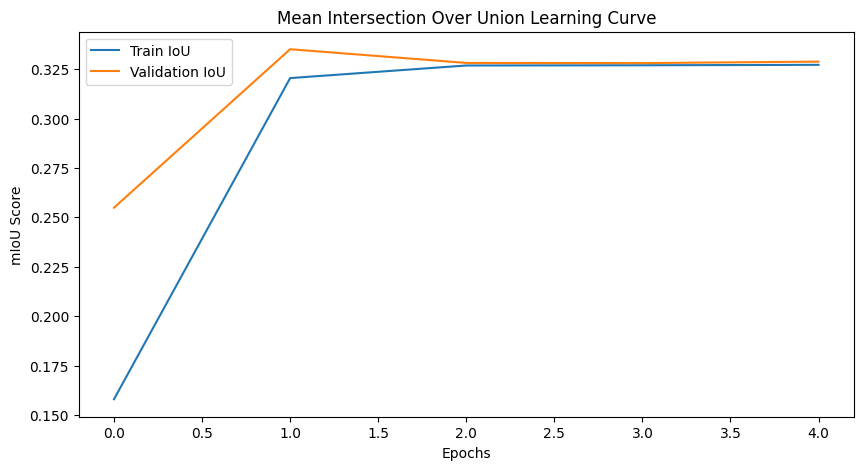

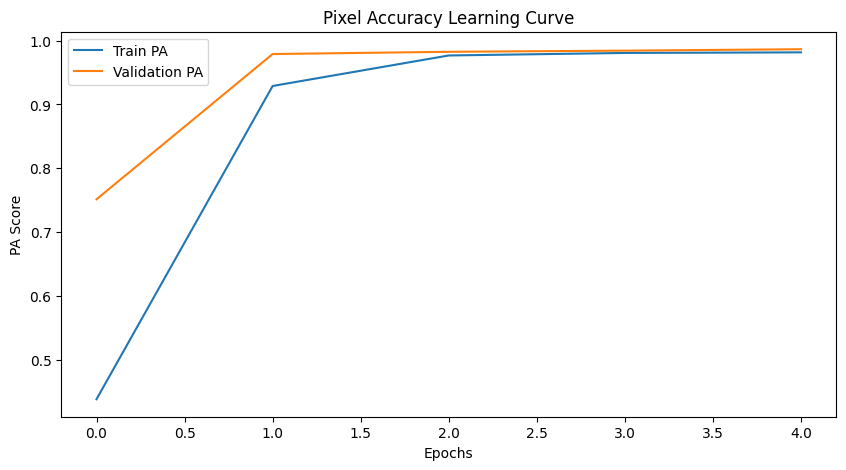

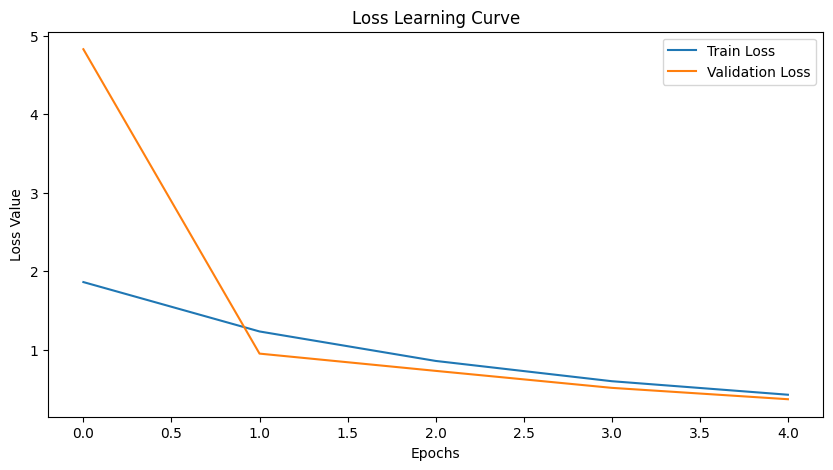

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(res, metric, label):
    plt.plot(res[metric], label=label)

def decorate_plot(ylabel, title):
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def visualize_metrics(res, metric1, metric2, label1, label2, title, ylabel):
    plt.figure(figsize=(10, 5))
    plot_metric(res, metric1, label1)
    plot_metric(res, metric2, label2)
    decorate_plot(ylabel, title)

def plot_training_results(res):
    visualize_metrics(res, "tr_iou", "val_iou", "Train IoU", "Validation IoU",
                      "Mean Intersection Over Union Learning Curve", "mIoU Score")
    visualize_metrics(res, "tr_pa", "val_pa", "Train PA", "Validation PA",
                      "Pixel Accuracy Learning Curve", "PA Score")
    visualize_metrics(res, "tr_loss", "val_loss", "Train Loss", "Validation Loss",
                      "Loss Learning Curve", "Loss Value")


plot_training_results(history)


# 3 Улучшение бейзлайна

Для повышения качества были внесены следующие улучшения:

1. Замена энкодера на ResNet-50 — использование более мощного и глубокого энкодера, такого как ResNet-50, позволяет извлекать более выразительные и устойчивые признаки из входных изображений. .

2. Комбинирование функций потерь: Cross-Entropy Loss и Dice Loss — объединение этих двух функций позволяет учитывать сразу несколько аспектов качества предсказаний:

- Cross-Entropy Loss эффективно оптимизирует точность классификации на уровне отдельных пикселей и хорошо справляется с различимыми классами.

- Dice Loss ориентирован на максимизацию перекрытия между предсказанной и истинной масками, что особенно важно при наличии дисбаланса классов или работы с мелкими объектами.

Совместное использование этих функций помогает сбалансировать обучение модели, улучшая как пиксельную точность, так и пространственную согласованность предсказаний.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm

def dice_loss(pred, target, num_classes=9):
    smooth = 1e-6
    pred = pred.argmax(dim=1)
    if target.dim() == 4:
        target = target.argmax(dim=1)

    dice = 0
    for i in range(num_classes):
        pred_f = (pred == i).float()
        target_f = (target == i).float()
        intersection = (pred_f * target_f).sum()
        dice += (2. * intersection + smooth) / (pred_f.sum() + target_f.sum() + smooth)
    return 1 - (dice / num_classes)

def combined_loss(outputs, masks, ce_weight=0.5, dice_weight=0.5, num_classes=9):
    if masks.dim() == 4:
        masks = masks.argmax(dim=1)

    ce = nn.CrossEntropyLoss()(outputs, masks)
    dice = dice_loss(outputs, masks, num_classes)
    return ce_weight * ce + dice_weight * dice

def compute_pa(preds, gts):
    preds = preds.argmax(dim=1)
    if gts.dim() == 4:
        gts = gts.argmax(dim=1)
    correct = (preds == gts).float().sum()
    total = gts.numel()
    return correct / total

def compute_miou(preds, gts, num_classes):
    preds = preds.argmax(dim=1)
    if gts.dim() == 4:
        gts = gts.argmax(dim=1)

    iou = 0
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (gts == cls)
        intersection = (pred_inds & target_inds).float().sum()
        union = (pred_inds | target_inds).float().sum()
        if union == 0:
            iou += 1
        else:
            iou += intersection / union
    return iou / num_classes

def train(model, tr_dl, val_dl, loss_fn='combined', opt=None, device=None, epochs=50, save_prefix='unet', save_path="saved_models", n_cls=9):
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, not_improve = np.inf, 0
    early_stop_threshold = 7

    os.makedirs(save_path, exist_ok=True)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if opt is None:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    print(f"Start training process on {device}...")
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_tr_loss, epoch_tr_pa, epoch_tr_iou = 0, 0, 0

        for ims, gts in tqdm(tr_dl, desc=f"Epoch {epoch} Training"):
            ims, gts = ims.to(device), gts.to(device)
            opt.zero_grad()
            preds = model(ims)
            loss = compute_loss(preds, gts, loss_fn)
            loss.backward()
            opt.step()
            epoch_tr_loss += loss.item()
            epoch_tr_pa += compute_pa(preds, gts)
            epoch_tr_iou += compute_miou(preds, gts, n_cls)

        model.eval()
        epoch_val_loss, epoch_val_pa, epoch_val_iou = 0, 0, 0
        with torch.no_grad():
            for ims, gts in tqdm(val_dl, desc=f"Epoch {epoch} Validation"):
                ims, gts = ims.to(device), gts.to(device)
                preds = model(ims)
                loss = compute_loss(preds, gts, loss_fn)
                epoch_val_loss += loss.item()
                epoch_val_pa += compute_pa(preds, gts)
                epoch_val_iou += compute_miou(preds, gts, n_cls)

        epoch_tr_loss /= tr_len
        epoch_tr_pa /= tr_len
        epoch_tr_iou /= tr_len
        epoch_val_loss /= val_len
        epoch_val_pa /= val_len
        epoch_val_iou /= val_len

        print(f"\nEpoch {epoch} Results:")
        print(f"Train Loss: {epoch_tr_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        print(f"Train PA: {epoch_tr_pa:.4f} | Val PA: {epoch_val_pa:.4f}")
        print(f"Train mIoU: {epoch_tr_iou:.4f} | Val mIoU: {epoch_val_iou:.4f}")

        if epoch_val_loss < best_loss:
            print(f"Validation loss improved from {best_loss:.4f} to {epoch_val_loss:.4f}")
            best_loss = epoch_val_loss
            not_improve = 0
            torch.save(model.state_dict(), f"{save_path}/{save_prefix}_best.pt")
        else:
            not_improve += 1
            print(f"No improvement for {not_improve}/{early_stop_threshold} epochs")
            if not_improve >= early_stop_threshold:
                print("Early stopping triggered")
                break

        tr_loss.append(epoch_tr_loss)
        tr_pa.append(epoch_tr_pa)
        tr_iou.append(epoch_tr_iou)
        val_loss.append(epoch_val_loss)
        val_pa.append(epoch_val_pa)
        val_iou.append(epoch_val_iou)

    return {
        "tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou,
        "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou
    }

In [ ]:
model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=n_classes)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.05)
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
history = train(model=model,tr_dl=tr_dl,val_dl=val_dl,loss_fn=combined_loss,opt=optimizer,device=device,epochs=5,save_prefix="cricket",n_cls=n_classes)

Start training process on cuda...


Epoch 1 Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]



Epoch 1 Results:
Train Loss: 0.2728 | Val Loss: 3310097.0000
Train PA: 0.9250 | Val PA: 0.9865
Train mIoU: 0.7303 | Val mIoU: 0.7763
Validation loss improved from inf to 3310097.0000


Epoch 2 Validation: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]



Epoch 2 Results:
Train Loss: 0.1349 | Val Loss: 184.6526
Train PA: 0.9817 | Val PA: 0.9865
Train mIoU: 0.7757 | Val mIoU: 0.7763
Validation loss improved from 3310097.0000 to 184.6526


Epoch 3 Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]



Epoch 3 Results:
Train Loss: 0.1321 | Val Loss: 0.1830
Train PA: 0.9816 | Val PA: 0.9865
Train mIoU: 0.7757 | Val mIoU: 0.7763
Validation loss improved from 184.6526 to 0.1830


Epoch 4 Validation: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]



Epoch 4 Results:
Train Loss: 0.1306 | Val Loss: 0.6012
Train PA: 0.9818 | Val PA: 0.9865
Train mIoU: 0.7758 | Val mIoU: 0.7763
No improvement for 1/7 epochs


Epoch 5 Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]



Epoch 5 Results:
Train Loss: 0.1303 | Val Loss: 0.1249
Train PA: 0.9816 | Val PA: 0.9865
Train mIoU: 0.7757 | Val mIoU: 0.7763
Validation loss improved from 0.1830 to 0.1249


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric(res, metric, label):
    metric_data = [x.cpu().numpy() if torch.is_tensor(x) else np.array(x) for x in res[metric]]
    plt.plot(metric_data, label=label)

def decorate_plot(ylabel, title):
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_metrics(res, metric1, metric2, label1, label2, title, ylabel):
    plt.figure(figsize=(10, 5))
    plot_metric(res, metric1, label1)
    plot_metric(res, metric2, label2)
    decorate_plot(ylabel, title)

def plot_training_results(res):
    processed_res = {
        "tr_iou": [x.cpu().numpy() if torch.is_tensor(x) else x for x in res["tr_iou"]],
        "val_iou": [x.cpu().numpy() if torch.is_tensor(x) else x for x in res["val_iou"]],
        "tr_pa": [x.cpu().numpy() if torch.is_tensor(x) else x for x in res["tr_pa"]],
        "val_pa": [x.cpu().numpy() if torch.is_tensor(x) else x for x in res["val_pa"]],
        "tr_loss": [x.cpu().numpy() if torch.is_tensor(x) else x for x in res["tr_loss"]],
        "val_loss": [x.cpu().numpy() if torch.is_tensor(x) else x for x in res["val_loss"]]
    }

    visualize_metrics(processed_res, "tr_iou", "val_iou",
                     "Train IoU", "Validation IoU",
                     "Mean Intersection Over Union Learning Curve", "mIoU Score")

    visualize_metrics(processed_res, "tr_pa", "val_pa",
                     "Train PA", "Validation PA",
                     "Pixel Accuracy Learning Curve", "PA Score")

    visualize_metrics(processed_res, "tr_loss", "val_loss",
                     "Train Loss", "Validation Loss",
                     "Loss Learning Curve", "Loss Value")

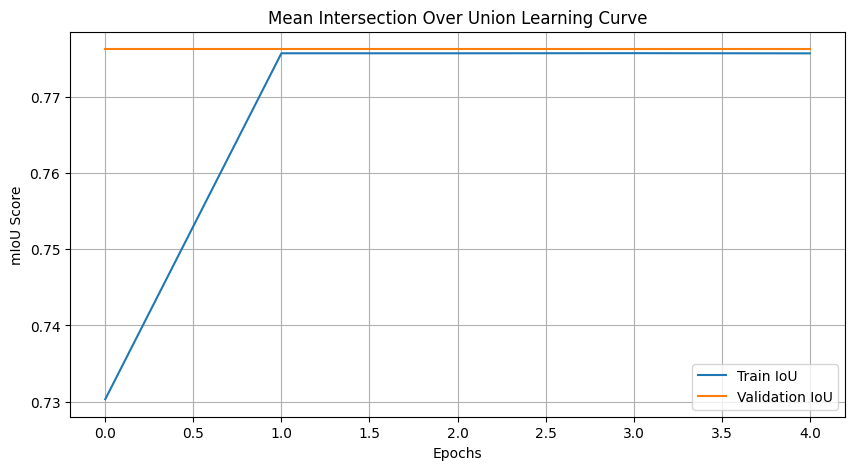

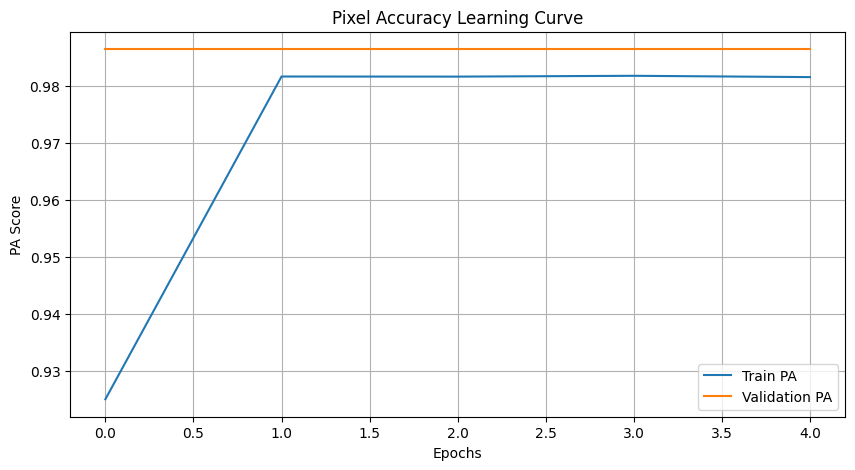

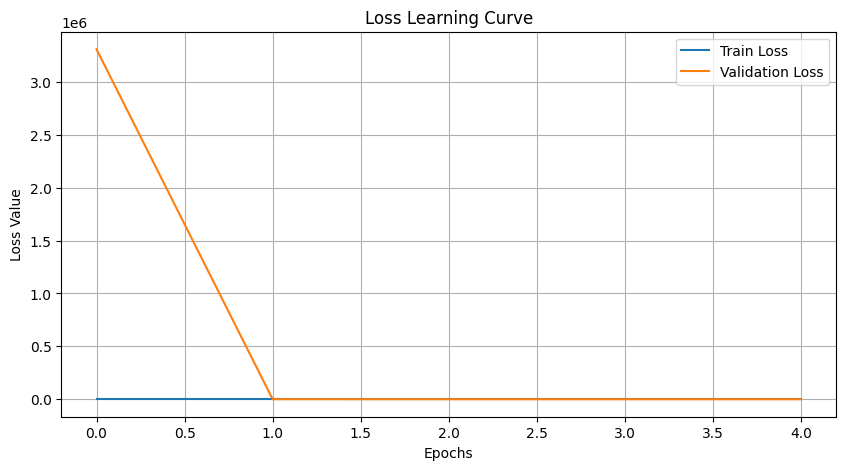

In [ ]:
plot_training_results(history)

Как видно по графикам, а также по числовым метрикам, изменение модели энкодера, а также функции потерь сильно улучшили метрики модели, особенно IoU.

# 4 Имплементация алгоритма машинного обучения

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import time
import os
from tqdm import tqdm

def to_contiguous(inp):
    return inp.contiguous().view(-1)

def compute_pa(pred, gt):
    with torch.no_grad():
        pred_labels = torch.argmax(F.softmax(pred, dim=1), dim=1)
        gt_labels = torch.argmax(gt, dim=1) if gt.ndim == 4 else gt
        match = (pred_labels == gt_labels).int()
    return float(match.sum()) / float(match.numel())

def compute_miou(pred, gt, n_cls, eps=1e-10):
    with torch.no_grad():
        pred_labels = torch.argmax(F.softmax(pred, dim=1), dim=1)
        gt_labels = torch.argmax(gt, dim=1) if gt.ndim == 4 else gt
        pred_flat = to_contiguous(pred_labels)
        gt_flat = to_contiguous(gt_labels)

        iou_per_class = []
        for c in range(n_cls):
            match_pred = pred_flat == c
            match_gt = gt_flat == c

            if match_gt.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                union = torch.logical_or(match_pred, match_gt).sum().float().item()
                iou = (intersect + eps) / (union + eps)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def compute_loss(pred, gt, loss_fn):
    gt_labels = torch.argmax(gt, dim=1) if gt.ndim == 4 else gt
    return loss_fn(pred, gt_labels)

def tic_toc(start_time=None):
    return time.time() if start_time is None else time.time() - start_time

def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path="saved_models", n_cls=9):
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve = np.inf, 1, 0
    early_stop_threshold = 7

    os.makedirs(save_path, exist_ok=True)
    model.to(device)

    train_start = tic_toc()
    print("Start training process...")
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for ims, gts in tqdm(tr_dl):
            ims, gts = ims.to(device), gts.to(device)
            preds = model(ims)
            loss_ = compute_loss(preds, gts, loss_fn)
            tr_loss_ += loss_.item()
            tr_pa_ += compute_pa(preds, gts)
            tr_iou_ += compute_miou(preds, gts, n_cls)
            loss_.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        print(f"Epoch {epoch} validation process is started...")
        with torch.no_grad():
            for ims, gts in tqdm(val_dl):
                ims, gts = ims.to(device), gts.to(device)
                preds = model(ims)
                val_loss_ += compute_loss(preds, gts, loss_fn).item()
                val_pa_ += compute_pa(preds, gts)
                val_iou_ += compute_miou(preds, gts, n_cls)

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"Epoch {epoch} train process results:")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")
        if val_loss_ < best_loss:
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")
        else:
            not_improve += 1
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print("Stopping training due to early stopping criteria.")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)
        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

    print(f"Training completed in {(tic_toc(train_start)) / 60:.2f} minutes.")
    return {
        "tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
        "val_loss": val_loss, "val_iou": val_iou, "val_pa": val_pa
    }

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model=model, tr_dl=tr_dl, val_dl=val_dl, loss_fn=loss_fn, opt=optimizer,device=device,epochs=5,save_prefix="cricket",n_cls=n_classes)

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()

        self.enc1 = self._conv_block(3, 64)
        self.enc2 = self._conv_block(64, 128)
        self.enc3 = self._conv_block(128, 256)

        self.bottleneck = self._conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

In [ ]:
def initialize_weights(module):
    classname = module.__class__.__name__
    if classname in ('Conv2d', 'ConvTranspose2d'):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif classname == 'BatchNorm2d':
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
    elif classname == 'Linear':
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet( num_classes=num_classes)
model.apply(initialize_weights)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0.0001,betas=(0.9, 0.999),eps=1e-08)

Model initialized on cuda
Total parameters: 7,703,497


In [ ]:
history = train(model=model,tr_dl=tr_dl,val_dl=val_dl,loss_fn=loss_fn,opt=optimizer,device=device,epochs=5,save_prefix="cricket",n_cls=n_classes)

Start training process...
Epoch 1 train process is started...


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Epoch 1 validation process is started...


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 train process results:
Train Time         -> 18.870 secs
Train Loss         -> 2.256
Train PA           -> 0.435
Train IoU          -> 0.156
Validation Loss    -> 1.258
Validation PA      -> 0.832
Validation IoU     -> 0.295

Loss decreased from inf to 1.258!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Epoch 2 validation process is started...


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2 train process results:
Train Time         -> 19.313 secs
Train Loss         -> 1.059
Train PA           -> 0.827
Train IoU          -> 0.291
Validation Loss    -> 0.892
Validation PA      -> 0.875
Validation IoU     -> 0.308

Loss decreased from 1.258 to 0.892!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Epoch 3 validation process is started...


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3 train process results:
Train Time         -> 18.965 secs
Train Loss         -> 0.567
Train PA           -> 0.936
Train IoU          -> 0.323
Validation Loss    -> 0.588
Validation PA      -> 0.929
Validation IoU     -> 0.321

Loss decreased from 0.892 to 0.588!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


Epoch 4 validation process is started...


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4 train process results:
Train Time         -> 20.313 secs
Train Loss         -> 0.364
Train PA           -> 0.969
Train IoU          -> 0.329
Validation Loss    -> 0.410
Validation PA      -> 0.960
Validation IoU     -> 0.325

Loss decreased from 0.588 to 0.410!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Epoch 5 validation process is started...


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5 train process results:
Train Time         -> 18.309 secs
Train Loss         -> 0.257
Train PA           -> 0.979
Train IoU          -> 0.328
Validation Loss    -> 0.305
Validation PA      -> 0.969
Validation IoU     -> 0.325

Loss decreased from 0.410 to 0.305!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training completed in 1.60 minutes.


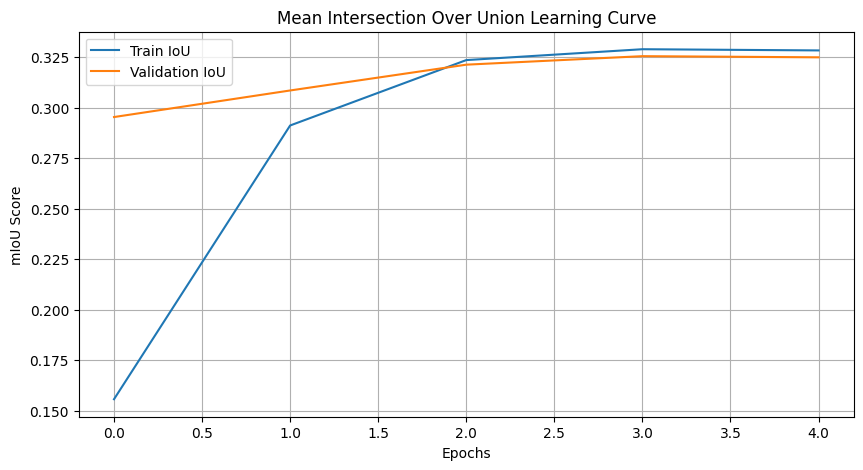

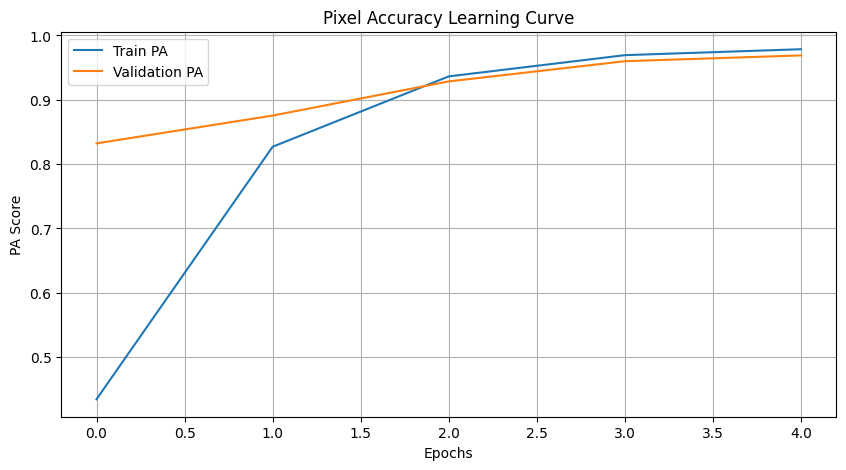

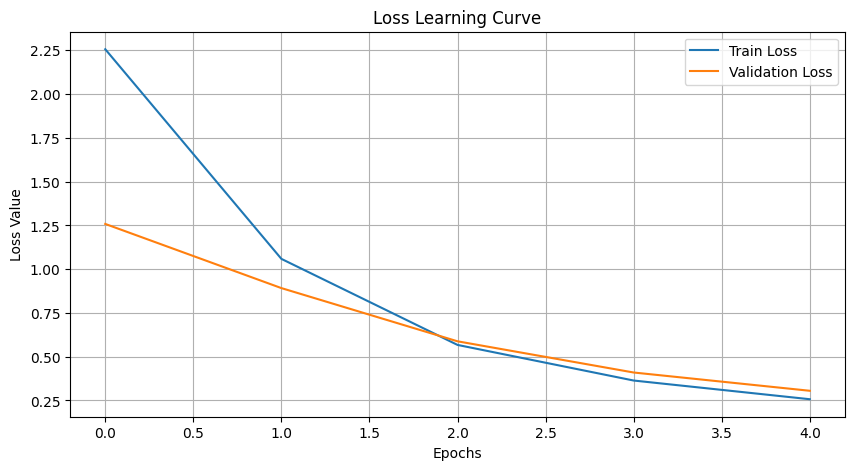

In [ ]:
plot_training_results(history)

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

## Улучшенный бейзлайн для собственной реализации

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm

def dice_loss(pred, target, num_classes=9):
    smooth = 1e-6
    pred = pred.argmax(dim=1)
    if target.dim() == 4:
        target = target.argmax(dim=1)

    dice = 0
    for i in range(num_classes):
        pred_f = (pred == i).float()
        target_f = (target == i).float()
        intersection = (pred_f * target_f).sum()
        dice += (2. * intersection + smooth) / (pred_f.sum() + target_f.sum() + smooth)
    return 1 - (dice / num_classes)

def combined_loss(outputs, masks, ce_weight=0.5, dice_weight=0.5, num_classes=9):
    if masks.dim() == 4:
        masks = masks.argmax(dim=1)

    ce = nn.CrossEntropyLoss()(outputs, masks)
    dice = dice_loss(outputs, masks, num_classes)
    return ce_weight * ce + dice_weight * dice

def compute_pa(preds, gts):
    preds = preds.argmax(dim=1)
    if gts.dim() == 4:
        gts = gts.argmax(dim=1)
    correct = (preds == gts).float().sum()
    total = gts.numel()
    return correct / total

def compute_miou(preds, gts, num_classes):
    preds = preds.argmax(dim=1)
    if gts.dim() == 4:
        gts = gts.argmax(dim=1)

    iou = 0
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (gts == cls)
        intersection = (pred_inds & target_inds).float().sum()
        union = (pred_inds | target_inds).float().sum()
        if union == 0:
            iou += 1
        else:
            iou += intersection / union
    return iou / num_classes

def train(model, tr_dl, val_dl, loss_fn='combined', opt=None, device=None, epochs=50, save_prefix='unet', save_path="saved_models", n_cls=9):
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, not_improve = np.inf, 0
    early_stop_threshold = 7

    os.makedirs(save_path, exist_ok=True)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if opt is None:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    print(f"Start training process on {device}...")
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_tr_loss, epoch_tr_pa, epoch_tr_iou = 0, 0, 0

        for ims, gts in tqdm(tr_dl, desc=f"Epoch {epoch} Training"):
            ims, gts = ims.to(device), gts.to(device)
            opt.zero_grad()
            preds = model(ims)
            loss = compute_loss(preds, gts, loss_fn)
            loss.backward()
            opt.step()
            epoch_tr_loss += loss.item()
            epoch_tr_pa += compute_pa(preds, gts)
            epoch_tr_iou += compute_miou(preds, gts, n_cls)

        model.eval()
        epoch_val_loss, epoch_val_pa, epoch_val_iou = 0, 0, 0
        with torch.no_grad():
            for ims, gts in tqdm(val_dl, desc=f"Epoch {epoch} Validation"):
                ims, gts = ims.to(device), gts.to(device)
                preds = model(ims)
                loss = compute_loss(preds, gts, loss_fn)
                epoch_val_loss += loss.item()
                epoch_val_pa += compute_pa(preds, gts)
                epoch_val_iou += compute_miou(preds, gts, n_cls)

        epoch_tr_loss /= tr_len
        epoch_tr_pa /= tr_len
        epoch_tr_iou /= tr_len
        epoch_val_loss /= val_len
        epoch_val_pa /= val_len
        epoch_val_iou /= val_len

        print(f"\nEpoch {epoch} Results:")
        print(f"Train Loss: {epoch_tr_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        print(f"Train PA: {epoch_tr_pa:.4f} | Val PA: {epoch_val_pa:.4f}")
        print(f"Train mIoU: {epoch_tr_iou:.4f} | Val mIoU: {epoch_val_iou:.4f}")

        if epoch_val_loss < best_loss:
            print(f"Validation loss improved from {best_loss:.4f} to {epoch_val_loss:.4f}")
            best_loss = epoch_val_loss
            not_improve = 0
            torch.save(model.state_dict(), f"{save_path}/{save_prefix}_best.pt")
        else:
            not_improve += 1
            print(f"No improvement for {not_improve}/{early_stop_threshold} epochs")
            if not_improve >= early_stop_threshold:
                print("Early stopping triggered")
                break

        tr_loss.append(epoch_tr_loss)
        tr_pa.append(epoch_tr_pa)
        tr_iou.append(epoch_tr_iou)
        val_loss.append(epoch_val_loss)
        val_pa.append(epoch_val_pa)
        val_iou.append(epoch_val_iou)

    return {
        "tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou,
        "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou
    }

In [ ]:
istory = train(model=model,tr_dl=tr_dl,val_dl=val_dl,loss_fn=combined_loss,opt=optimizer,device=device,epochs=5,save_prefix="cricket",n_cls=n_classes)

Start training process on cuda...


Epoch 1 Validation: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]



Epoch 1 Results:
Train Loss: 0.4668 | Val Loss: 0.4607
Train PA: 0.9803 | Val PA: 0.9714
Train mIoU: 0.1158 | Val mIoU: 0.1637
Validation loss improved from inf to 0.4607


Epoch 2 Validation: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]



Epoch 2 Results:
Train Loss: 0.4407 | Val Loss: 0.4284
Train PA: 0.9810 | Val PA: 0.9715
Train mIoU: 0.1550 | Val mIoU: 0.2193
Validation loss improved from 0.4607 to 0.4284


Epoch 3 Validation: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]



Epoch 3 Results:
Train Loss: 0.4281 | Val Loss: 0.4456
Train PA: 0.9812 | Val PA: 0.9717
Train mIoU: 0.1681 | Val mIoU: 0.1637
No improvement for 1/7 epochs


Epoch 4 Validation: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]



Epoch 4 Results:
Train Loss: 0.3965 | Val Loss: 0.4169
Train PA: 0.9813 | Val PA: 0.9717
Train mIoU: 0.2334 | Val mIoU: 0.2192
Validation loss improved from 0.4284 to 0.4169


Epoch 5 Validation: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]



Epoch 5 Results:
Train Loss: 0.3960 | Val Loss: 0.3431
Train PA: 0.9812 | Val PA: 0.9721
Train mIoU: 0.2268 | Val mIoU: 0.3860
Validation loss improved from 0.4169 to 0.3431


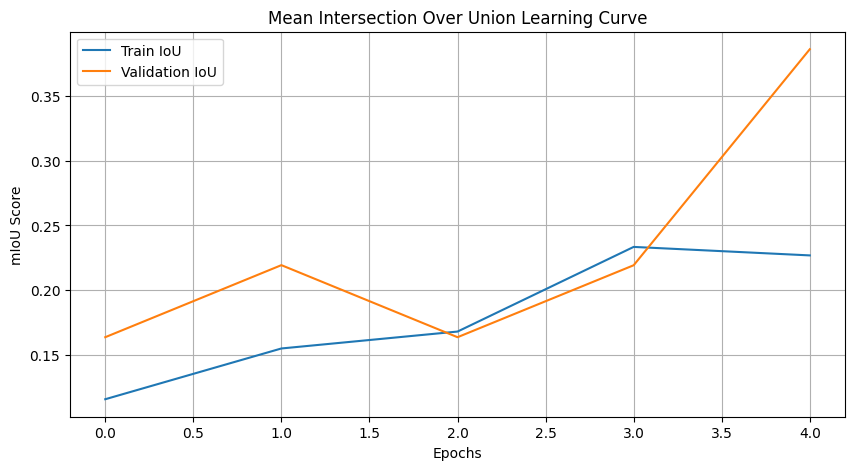

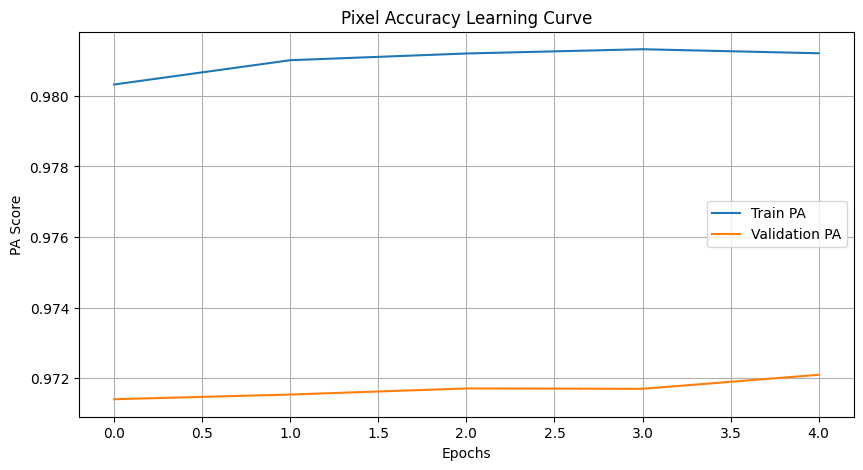

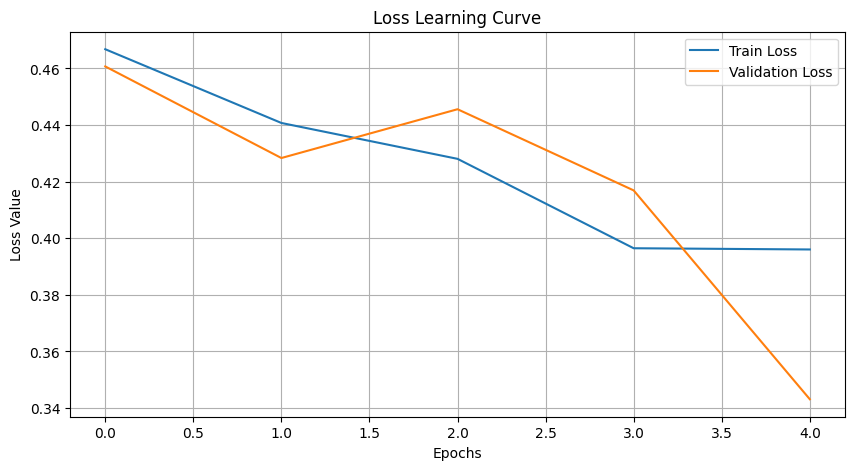

In [ ]:
plot_training_results(history)

На улучшенном бейзлайне модель продемонстрировала небольшой рост всех метрик.